In [1]:
from pickle import load
import numpy as np

In [2]:
with open("../Datos/Procesados/alphabet_landmarks_spread.pkl", "rb") as f:
    total_results = load(f)

In [3]:
type(total_results)

dict

In [4]:
total_results.keys()

dict_keys(['A', 'B', 'C', 'CH', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'LL', 'M', 'N', 'N_', 'O', 'P', 'Q', 'R', 'RR', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [5]:
type(total_results["A"])

dict

In [6]:
total_results["A"].keys()

dict_keys(['n_frames', 'fps', 'frame_width', 'frame_height', 'landmarks'])

In [7]:
type(total_results["A"]["landmarks"])

dict

In [8]:
total_results["A"]["landmarks"].keys()

dict_keys(['face', 'pose', 'pose_world', 'left_hand', 'right_hand'])

In [9]:
type(total_results["A"]["landmarks"]["face"])

numpy.ndarray

In [10]:
total_results["A"]["landmarks"]["face"].dtype

dtype('float64')

In [11]:
total_results["A"]["landmarks"]["face"].shape

(87, 478, 3)

In [12]:
pi = np.float64(np.pi)

In [13]:
def azimuth(x, y, z):
    """
    Given a unit 3D real vector, returns the azimuth of the vector.
    """
    # return np.arctan2(y, x)
    if np.isclose(x, 0):
        if np.isclose(y, 0):
            return np.float64(0)
        else:
            return np.sign(y) * pi / 2.
    else:
        aux = np.arctan(y/x)
        if x>0:
            return aux
        elif y>0:
            return aux + pi
        else:
            return aux - pi

def colatitude(x, y, z):
    """
    Given a unit 3D real vector, returns the colatitude of the vector.
    """
    return np.arccos(np.clip(z, -1, 1))

In [14]:
def max_left_shoulder_rotation(left_shoulder_direction):
    """
    Given the left shoulder direction in the left shoulder basis, returns
    the normal vector of the left arm plane when it is maximally rotated.

    Input: array of shape (3,).

    Output: array of shape (3,).
    """
    x, y, z = left_shoulder_direction

    if np.isclose(y, 0):
        aux_vector = np.array([0, -1, 0], dtype=np.float64)
    elif np.isclose(y, 1):
        aux_vector = np.array([0, 0, -1], dtype=np.float64)
    elif np.isclose(y, -1):
        aux_vector = np.array([0, 0, 1], dtype=np.float64)
    else:
        aux_vector = np.sign(y) * np.array([x, y - 1./y, z], dtype=np.float64)
        aux_vector /= np.linalg.norm(aux_vector)


    if np.isclose(y, 1):
        angle = pi / 4.
    elif np.isclose(y, -1):
        angle = 0.
    else:
        tita = colatitude(x, z, y)
        fi = azimuth(x, z, y)
        if z<=0:
            if y>=0:
                angle = (fi + pi / 4.) * (2. * tita / pi - 1.)
            else:
                angle = (fi + pi / 2.) * (2. * tita / pi - 1.)
        else:
            if y>=0:
                angle = tita / 2. - fi - pi / 4.
            else:
                angle = - fi + (2. * fi + pi / 2.) * (2. * tita / pi - 1.)


    aux_normal = np.cross(aux_vector, left_shoulder_direction)
    left_elbow_direction_max_rotation = np.cos(angle) * aux_vector + np.sin(angle) * aux_normal
    
    return np.cross(left_shoulder_direction, left_elbow_direction_max_rotation)

def max_right_shoulder_rotation(right_shoulder_direction):
    """
    Given the right shoulder direction in the right shoulder basis, returns
    the normal vector of the right arm plane when it is maximally rotated.

    Input: array of shape (3,).

    Output: array of shape (3,).
    """
    x, y, z = right_shoulder_direction

    if np.isclose(y, 0):
        aux_vector = np.array([0, -1, 0], dtype=np.float64)
    elif np.isclose(y, 1):
        aux_vector = np.array([0, 0, 1], dtype=np.float64)
    elif np.isclose(y, -1):
        aux_vector = np.array([0, 0, -1], dtype=np.float64)
    else:
        aux_vector = np.sign(y) * np.array([x, y - 1./y, z], dtype=np.float64)
        aux_vector /= np.linalg.norm(aux_vector)


    if np.isclose(y, 1):
        angle = pi / 4.
    elif np.isclose(y, -1):
        angle = 0.
    else:
        tita = colatitude(x, z, y)
        fi = azimuth(x, z, y)
        if z>=0:
            if y>=0:
                angle = (pi / 4. - fi) * (2. * tita / pi - 1.)
            else:
                angle = (pi / 2. - fi) * (2. * tita / pi - 1.)
        else:
            if y>=0:
                angle = tita / 2. + fi - pi / 4.
            else:
                angle = fi + (pi / 2. - 2. * fi) * (2. * tita / pi - 1.)


    aux_normal = np.cross(right_shoulder_direction, aux_vector)
    right_elbow_direction_max_rotation = np.cos(angle) * aux_vector + np.sin(angle) * aux_normal
    
    return np.cross(right_shoulder_direction, right_elbow_direction_max_rotation)

In [15]:
def pose2arm_position(half_pose_landmarks, frame_width, frame_height):
    """
    Given an array of shape (14, 3) or (14, 4) that describes the pose landmarks of the trunk
    of a frame, and the width and height of the frame, returns information of the arms.

    Inputs:
      - half_pose_landmarks (ndarray of shape (14, 3) or (14, 4))
      - frame_width (int)
      - frame_height (int)

    Output: arms_position_dict (dict)
      - left_shoulder_direction (respect to shoulder basis)
      - left_upperarm_length
      - left_shoulder_rotation [0, pi] (respect to max_left_shoulder_rotation)
      - left_elbow_angle
      - left_forearm_length
      - left_elbow_rotation [-pi/2, pi/2]
      - left_wrist_rotation [0, 2pi) (respect to hand basis)
      - left_wrist_inclination [0, pi] (respect to hand basis)
      - left_pinky_vector (respect to hand basis)
      - left_index_vector (respect to hand basis)
      - left_thumb_vector (respect to hand basis)
      
      - right_shoulder_direction (respect to shoulder basis)
      - right_upperarm_length
      - right_shoulder_rotation [0, pi] (respect to max_right_shoulder_rotation)
      - right_elbow_angle
      - right_forearm_length
      - right_elbow_rotation [-pi/2, pi/2]
      - right_wrist_rotation [0, 2pi) (respect to hand basis)
      - right_wrist_inclination [0, pi] (respect to hand basis)
      - right_pinky_vector (respect to hand basis)
      - right_index_vector (respect to hand basis)
      - right_thumb_vector (respect to hand basis)
    """
    # Define the scale array
    scale = np.array([frame_width, frame_height, frame_width], dtype=np.float64)
    # Get the unnormalized half_pose_landmarks
    half_pose_landmarks_ = half_pose_landmarks[:, :3] * scale


    # Define the left shoulder ortonormal basis
    # The first vector is going out of the body in the direction of the shoulders
    # The second is going downwards to the hip
    # The third is going backwards
    left_shoulder_basis = np.empty((3, 3), dtype=np.float64)
    left_shoulder_basis[:, 0] = half_pose_landmarks_[0] - half_pose_landmarks_[1]
    left_shoulder_basis[:, 2] = np.cross(left_shoulder_basis[:, 0], half_pose_landmarks_[12] - half_pose_landmarks_[0])
    left_shoulder_basis[:, 1] = np.cross(left_shoulder_basis[:, 2], left_shoulder_basis[:, 0])
    left_shoulder_basis /= np.linalg.norm(left_shoulder_basis, axis=0, keepdims=True)

    # Obtain the vector of the left upperarm in the basis of the image
    left_upperarm_vector = half_pose_landmarks_[2] - half_pose_landmarks_[0]
    # Obtain the length of the left upperarm
    left_upperarm_length = np.linalg.norm(left_upperarm_vector)
    # Change the basis of the left upperarm normalized vector
    left_shoulder_direction = (left_upperarm_vector / left_upperarm_length) @ left_shoulder_basis


    # Obtain the vector of the left forearm in the basis of the image
    left_forearm_vector = half_pose_landmarks_[4] - half_pose_landmarks_[2]
    # Obtain the length of the left forearm
    left_forearm_length = np.linalg.norm(left_forearm_vector)
    # Obtain the direction of the forearm
    left_forearm_direction = left_forearm_vector / left_forearm_length
    # Obtain the angle of the elbow
    left_elbow_angle = pi - np.arccos(np.clip(np.dot(left_upperarm_vector, left_forearm_direction) / left_upperarm_length, -1, 1))

    if np.isclose(left_elbow_angle, pi, atol=1e-3):
        # If the elbow angle is close to pi, set it as pi and we assume that the shoulder is maximally rotated
        left_elbow_angle = pi
        left_shoulder_rotation = np.float64(0)
    else:
        # Otherwise, obtain the elbow direction on the shoulder basis
        left_elbow_direction = left_forearm_direction @ left_shoulder_basis
        # Obtain the unit normal vector of the plane containing the left arm
        left_arm_plane_normal_vector = np.cross(left_shoulder_direction, left_elbow_direction)
        left_arm_plane_normal_vector /= np.linalg.norm(left_arm_plane_normal_vector)
        # Obtain the normal vector of the plane of the left arm if the shoulder is maximally rotated
        left_arm_max_rotation_plane_normal_vector = max_left_shoulder_rotation(left_shoulder_direction)
        # Obtain an auxiliary vector to know the sign of the rotation (negative rotations are supposed to be anti-natural)
        aux_vector = np.cross(left_shoulder_direction, left_arm_max_rotation_plane_normal_vector)
        # Obtain the shoulder rotation (angle between the two normal vectors)
        left_shoulder_rotation = (np.sign(np.dot(left_arm_plane_normal_vector, aux_vector)) *
                                  np.arccos(np.clip(np.dot(left_arm_plane_normal_vector, left_arm_max_rotation_plane_normal_vector), -1, 1)))
        


    # Define the left hand ortonormal basis
    # The first vector is going out of the palm perpendicularly
    # The third is going from the wrist to the center of the palm
    # The second is going to the pinky making an orthonormal basis
    left_hand_basis = np.empty((3, 3), dtype=np.float64)
    left_hand_basis[:, 0] = np.cross(half_pose_landmarks_[6] - half_pose_landmarks_[4], half_pose_landmarks_[8] - half_pose_landmarks_[4])
    left_hand_basis[:, 2] = (half_pose_landmarks_[6] + half_pose_landmarks_[8])/2. - half_pose_landmarks_[4]
    left_hand_basis[:, 1] = np.cross(left_hand_basis[:, 2], left_hand_basis[:, 0])
    left_hand_basis /= np.linalg.norm(left_hand_basis, axis=0, keepdims=True)

    # Obtain hand vectors in left hand basis
    left_pinky_vector = (half_pose_landmarks_[6] - half_pose_landmarks_[4]) @ left_hand_basis
    left_index_vector = (half_pose_landmarks_[8] - half_pose_landmarks_[4]) @ left_hand_basis
    left_thumb_vector = (half_pose_landmarks_[10] - half_pose_landmarks_[4]) @ left_hand_basis

    # Obtain the forearm direction on the left hand basis
    left_wrist_direction = - left_forearm_direction @ left_hand_basis
    # Obtain the wrist rotation and inclination
    left_wrist_rotation = azimuth(*(left_wrist_direction * np.array([1, 1, -1], dtype=np.float64)))
    left_wrist_inclination = colatitude(*(left_wrist_direction * np.array([1, 1, -1], dtype=np.float64)))


    # Obtain the normal vector of the left palm in the case that the wrist is not inclinated
    # For this, rotate (1, 0, 0) `left_wrist_inclination` radians around (sin(`left_wrist_rotation`), -cos(`left_wrist_rotation`), 0) 
    a = np.cos(left_wrist_inclination)
    b = np.sin(left_wrist_inclination)
    c = np.cos(left_wrist_rotation)
    d = np.sin(left_wrist_rotation)
    left_palm_normal_vector_no_wrist_inclination = np.array([1.+(a-1.)*c*c, (a-1.)*c*d, b*c], dtype=np.float64)

    if np.isclose(left_elbow_angle, pi):
        # If the arm is completely extended, obtain the vector that, in the case that the arm is maximally rotated and the wrist not inclinated,
        # points from the left wrist to the pinky side perpendicularly to the arm
        aux_vector = max_left_shoulder_rotation(left_shoulder_direction) @ left_shoulder_basis.T @ left_hand_basis
        # Obtain the normal vector of the left palm in the case that the arm is maximally rotated and the wrist is not inclinated
        left_palm_normal_vector_max_arm_rotation = np.cross(left_wrist_direction, aux_vector)
        # Obtain the rotation of the arm (shoulder plus elbow)
        if np.dot(left_palm_normal_vector_no_wrist_inclination, aux_vector)>=0:
            left_arm_rotation = np.arccos(np.clip(
                np.dot(left_palm_normal_vector_no_wrist_inclination, left_palm_normal_vector_max_arm_rotation),
                -1, 1))
        else:
            left_arm_rotation = 2.*pi - np.arccos(np.clip(
                np.dot(left_palm_normal_vector_no_wrist_inclination, left_palm_normal_vector_max_arm_rotation),
                -1, 1))
        # Assumming that the arm rotation is equally distributed between shoulder and elbow, obtain each rotation
        left_shoulder_rotation = left_arm_rotation / 2.
        left_elbow_rotation = left_arm_rotation - left_shoulder_rotation - pi/2.

    else:
        # Otherwise, obtain the normal vector of the left palm in the case that the elbow is not rotated and the wrist is not inclinated
        left_palm_normal_vector_no_elbow_rotation = left_arm_plane_normal_vector @ left_shoulder_basis.T @ left_hand_basis
        # Obtain the angle between both normal vectors
        aux_vector = np.cross(left_palm_normal_vector_no_elbow_rotation, left_wrist_direction)
        left_elbow_rotation = np.sign(np.dot(left_palm_normal_vector_no_wrist_inclination, aux_vector)) * np.arccos(np.clip(
            np.dot(left_palm_normal_vector_no_wrist_inclination, left_palm_normal_vector_no_elbow_rotation), -1, 1))



    # Same for the right arm

    # The difference between the right shoulder basis and the left one is that the third vector
    # is going to the front, not backwards
    right_shoulder_basis = np.empty((3, 3), dtype=np.float64)
    right_shoulder_basis[:, 0] = half_pose_landmarks_[1] - half_pose_landmarks_[0]
    right_shoulder_basis[:, 2] = np.cross(right_shoulder_basis[:, 0], half_pose_landmarks_[13] - half_pose_landmarks_[1])
    right_shoulder_basis[:, 1] = np.cross(right_shoulder_basis[:, 2], right_shoulder_basis[:, 0])
    right_shoulder_basis /= np.linalg.norm(right_shoulder_basis, axis=0, keepdims=True)
    
    right_upperarm_vector = half_pose_landmarks_[3] - half_pose_landmarks_[1]
    right_upperarm_length = np.linalg.norm(right_upperarm_vector)
    right_shoulder_direction = (right_upperarm_vector / right_upperarm_length) @ right_shoulder_basis


    right_forearm_vector = half_pose_landmarks_[5] - half_pose_landmarks_[3]
    right_forearm_length = np.linalg.norm(right_forearm_vector)
    right_forearm_direction = right_forearm_vector / right_forearm_length
    right_elbow_angle = pi - np.arccos(np.clip(np.dot(right_upperarm_vector, right_forearm_direction) / right_upperarm_length, -1, 1))

    if np.isclose(right_elbow_angle, pi, atol=1e-3):
        right_elbow_angle = pi
        right_shoulder_rotation = np.float64(0)
    else:
        right_elbow_direction = right_forearm_direction @ right_shoulder_basis
        right_arm_plane_normal_vector = np.cross(right_shoulder_direction, right_elbow_direction)
        right_arm_plane_normal_vector /= np.linalg.norm(right_arm_plane_normal_vector)
        right_arm_max_rotation_plane_normal_vector = max_right_shoulder_rotation(right_shoulder_direction)
        aux_vector = np.cross(right_arm_max_rotation_plane_normal_vector, right_shoulder_direction)
        right_shoulder_rotation = (np.sign(np.dot(right_arm_plane_normal_vector, aux_vector)) *
                                   np.arccos(np.clip(np.dot(right_arm_plane_normal_vector, right_arm_max_rotation_plane_normal_vector), -1, 1)))


    # The difference between the right hand basis and the left one is that the third vector
    # is going to the thumbside, not to the pinkyside
    right_hand_basis = np.empty((3, 3), dtype=np.float64)
    right_hand_basis[:, 0] = np.cross(half_pose_landmarks_[9] - half_pose_landmarks_[5], half_pose_landmarks_[7] - half_pose_landmarks_[5])
    right_hand_basis[:, 2] = (half_pose_landmarks_[7] + half_pose_landmarks_[9])/2. - half_pose_landmarks_[5]
    right_hand_basis[:, 1] = np.cross(right_hand_basis[:, 2], right_hand_basis[:, 0])
    right_hand_basis /= np.linalg.norm(right_hand_basis, axis=0, keepdims=True)

    right_pinky_vector = (half_pose_landmarks_[7] - half_pose_landmarks_[5]) @ right_hand_basis
    right_index_vector = (half_pose_landmarks_[9] - half_pose_landmarks_[5]) @ right_hand_basis
    right_thumb_vector = (half_pose_landmarks_[11] - half_pose_landmarks_[5]) @ right_hand_basis

    right_wrist_direction = - right_forearm_direction @ right_hand_basis
    right_wrist_rotation = azimuth(*(right_wrist_direction * np.array([1, 1, -1], dtype=np.float64)))
    right_wrist_inclination = colatitude(*(right_wrist_direction * np.array([1, 1, -1], dtype=np.float64)))


    a = np.cos(right_wrist_inclination)
    b = np.sin(right_wrist_inclination)
    c = np.cos(right_wrist_rotation)
    d = np.sin(right_wrist_rotation)
    right_palm_normal_vector_no_wrist_inclination = np.array([1.+(a-1.)*c*c, (a-1.)*c*d, b*c], dtype=np.float64)
    
    if np.isclose(right_elbow_angle, pi):
        aux_vector = max_right_shoulder_rotation(right_shoulder_direction) @ right_shoulder_basis.T @ right_hand_basis
        right_palm_normal_vector_max_arm_rotation = np.cross(right_wrist_direction, aux_vector)
        if np.dot(right_palm_normal_vector_no_wrist_inclination, aux_vector)<=0:
            right_arm_rotation = np.arccos(np.clip(
                np.dot(right_palm_normal_vector_no_wrist_inclination, right_palm_normal_vector_max_arm_rotation),
                -1, 1))
        else:
            right_arm_rotation = 2.*pi - np.arccos(np.clip(
                np.dot(right_palm_normal_vector_no_wrist_inclination, right_palm_normal_vector_max_arm_rotation),
                -1, 1))
        right_shoulder_rotation = right_arm_rotation / 2.
        right_elbow_rotation = right_arm_rotation - right_shoulder_rotation - pi/2.
        
    else:
        right_palm_normal_vector_no_elbow_rotation = - right_arm_plane_normal_vector @ right_shoulder_basis.T @ right_hand_basis
        aux_vector = np.cross(right_palm_normal_vector_no_elbow_rotation, right_wrist_direction)
        right_elbow_rotation = - np.sign(np.dot(right_palm_normal_vector_no_wrist_inclination, aux_vector)) * np.arccos(np.clip(
            np.dot(right_palm_normal_vector_no_wrist_inclination, right_palm_normal_vector_no_elbow_rotation), -1, 1))


    arms_position_dict = {
        "left_shoulder_direction": left_shoulder_direction,
        "left_upperarm_length": left_upperarm_length,
        "left_shoulder_rotation": left_shoulder_rotation,
        "left_elbow_angle": left_elbow_angle,
        "left_forearm_length": left_forearm_length,
        "left_elbow_rotation": left_elbow_rotation,
        "left_wrist_rotation": left_wrist_rotation,
        "left_wrist_inclination": left_wrist_inclination,
        "left_pinky_vector": left_pinky_vector,
        "left_index_vector": left_index_vector,
        "left_thumb_vector": left_thumb_vector,

        "right_shoulder_direction": right_shoulder_direction,
        "right_upperarm_length": right_upperarm_length,
        "right_shoulder_rotation": right_shoulder_rotation,
        "right_elbow_angle": right_elbow_angle,
        "right_forearm_length": right_forearm_length,
        "right_elbow_rotation": right_elbow_rotation,
        "right_wrist_rotation": right_wrist_rotation,
        "right_wrist_inclination": right_wrist_inclination,
        "right_pinky_vector": right_pinky_vector,
        "right_index_vector": right_index_vector,
        "right_thumb_vector": right_thumb_vector
    }
    return arms_position_dict

In [16]:
def arm_position2pose(arms_position_dict, trunk_landmarks, frame_width, frame_height):
    """
    Given a dictionary like the returned by `pose2arm_position`, an array of shape (4, 3) with
    the landmarks of the trunk and the width and height of the frame, returns an array of shape
    (14, 3) with the landmarks of both arms and the trunk in the following order:
      0 - left shoulder
      1 - right shoulder
      2 - left elbow
      3 - right elbow
      4 - left wrist
      5 - right wrist
      6 - left pinky
      7 - right pinky
      8 - left index
      9 - right index
      10 - left thumb
      11 - right thumb
      12 - left hip
      13 - right hip

    The order of the input landmarks must be:
      0 - left shoulder
      1 - right shoulder
      2 - left hip
      3 - right hip

    Inputs:
      - arms_position_dict (dict)
      - trunk_landmarks (array)
      - frame_width (int)
      - frame_height (int)

    Output:
      - half_pose_landmarks (array)
    """
    # Define the scale array
    scale = np.array([frame_width, frame_height, frame_width], dtype=np.float64)
    # Initialize the unnormalized half_pose_landmarks
    half_pose_landmarks = np.empty((14, 3), dtype=np.float64)
    # Fill the rows of the trunk
    half_pose_landmarks[[0, 1, 12, 13]] = trunk_landmarks * scale


    # Define the left shoulder basis as in `pose2arm_position`
    left_shoulder_basis = np.empty((3, 3), dtype=np.float64)
    left_shoulder_basis[:, 0] = half_pose_landmarks[0] - half_pose_landmarks[1]
    left_shoulder_basis[:, 2] = np.cross(left_shoulder_basis[:, 0], half_pose_landmarks[12] - half_pose_landmarks[0])
    left_shoulder_basis[:, 1] = np.cross(left_shoulder_basis[:, 2], left_shoulder_basis[:, 0])
    left_shoulder_basis /= np.linalg.norm(left_shoulder_basis, axis=0, keepdims=True)

    # Obtain the left shoulder direction respect to the image basis
    left_shoulder_direction = arms_position_dict["left_shoulder_direction"] @ left_shoulder_basis.T
    # Obtain the landmarks of the left elbow
    half_pose_landmarks[2] = arms_position_dict["left_upperarm_length"] * left_shoulder_direction + half_pose_landmarks[0]


    if np.isclose(arms_position_dict["left_elbow_angle"], pi):
        # If the left arm is completely extended, obtain the left wrist landmarks
        left_forearm_direction = left_shoulder_direction
    else:
        # Otherwise, consider the normal vector of the plane of the left arm if the shoulder is maximally rotated
        left_arm_max_rotation_plane_normal_vector = max_left_shoulder_rotation(arms_position_dict["left_shoulder_direction"])
        # Obtain the cross product between the left shoulder direction and the normal vector
        aux_vector = np.cross(arms_position_dict["left_shoulder_direction"], left_arm_max_rotation_plane_normal_vector)
        # Using the left shoulder rotation, obtain the normal vector of the plain of the left arm
        left_arm_plane_normal_vector = (np.cos(arms_position_dict["left_shoulder_rotation"]) * left_arm_max_rotation_plane_normal_vector +
                                        np.sin(arms_position_dict["left_shoulder_rotation"]) * aux_vector)

        # Obtain the left forearm direction respect to the image basis
        aux_vector = np.cross(left_arm_plane_normal_vector, arms_position_dict["left_shoulder_direction"])
        left_forearm_direction = (- np.cos(arms_position_dict["left_elbow_angle"]) * arms_position_dict["left_shoulder_direction"] +
                                  np.sin(arms_position_dict["left_elbow_angle"]) * aux_vector) @ left_shoulder_basis.T

    # Obtain the left wrist landmarks
    half_pose_landmarks[4] = arms_position_dict["left_forearm_length"] * left_forearm_direction + half_pose_landmarks[2]

    if np.isclose(arms_position_dict["left_elbow_angle"], pi):
        # If the arm is completely extended, obtain the total rotation of the left arm
        left_arm_rotation = arms_position_dict["left_shoulder_rotation"] + arms_position_dict["left_elbow_rotation"] + pi/2.

        # Obtain the vector that, in the case that the arm is maximally rotated and the wrist not inclinated,
        # points from the left wrist to the pinky side perpendicularly to the arm
        aux_vector = max_left_shoulder_rotation(arms_position_dict["left_shoulder_direction"]) @ left_shoulder_basis.T
        # Obtain the normal vector of the left palm in the case that the arm is maximally rotated and the wrist is not inclinated
        left_palm_normal_vector_max_arm_rotation = np.cross(aux_vector, left_forearm_direction)

        # Obtain the normal vector of the left palm in the case that the arm is not inclinated
        left_palm_normal_vector_no_wrist_inclination = (np.cos(left_arm_rotation) * left_palm_normal_vector_max_arm_rotation +
                                                        np.sin(left_arm_rotation) * aux_vector)
    else:
        # Otherwise, obtain the normal vector of the left palm in the case that the elbow is not rotated and the wrist is not inclinated
        left_palm_normal_vector_no_elbow_rotation = left_arm_plane_normal_vector @ left_shoulder_basis.T
        aux_vector = np.cross(left_forearm_direction, left_palm_normal_vector_no_elbow_rotation)

        # Obtain the normal vector of the left palm in the case that the arm is not inclinated
        left_palm_normal_vector_no_wrist_inclination = (np.cos(arms_position_dict["left_elbow_rotation"]) * left_palm_normal_vector_no_elbow_rotation +
                                                       np.sin(arms_position_dict["left_elbow_rotation"]) * aux_vector)

    # Rename the vectors of the left hand basis if the wrist is not inclinated
    v1 = left_palm_normal_vector_no_wrist_inclination
    v3 = left_forearm_direction
    v2 = np.cross(v3, v1)

    # Obtain the left hand basis
    # For this, rotate the latter basis -`left_wrist_inclination` radians around (sin(`left_wrist_rotation`), -cos(`left_wrist_rotation`), 0)
    a = np.cos(arms_position_dict["left_wrist_inclination"])
    b = np.sin(arms_position_dict["left_wrist_inclination"])
    c = np.cos(arms_position_dict["left_wrist_rotation"])
    d = np.sin(arms_position_dict["left_wrist_rotation"])
    left_hand_basis = np.empty((3, 3), dtype=np.float64)
    left_hand_basis[:, 0] = (1.+(a-1.)*c*c) * v1 + (a-1.)*c*d * v2 - b*c * v3
    left_hand_basis[:, 1] = (1.+(a-1.)*d*d) * v2 + (a-1.)*c*d * v1 - b*d * v3
    left_hand_basis[:, 2] = b*c * v1 + b*d * v2 + a * v3

    # Obtain the pinky, index and thumb landmarks
    half_pose_landmarks[6] = arms_position_dict["left_pinky_vector"] @ left_hand_basis.T + half_pose_landmarks[4]
    half_pose_landmarks[8] = arms_position_dict["left_index_vector"] @ left_hand_basis.T + half_pose_landmarks[4]
    half_pose_landmarks[10] = arms_position_dict["left_thumb_vector"] @ left_hand_basis.T + half_pose_landmarks[4]



    # Same for the right arm

    right_shoulder_basis = np.empty((3, 3), dtype=np.float64)
    right_shoulder_basis[:, 0] = half_pose_landmarks[1] - half_pose_landmarks[0]
    right_shoulder_basis[:, 2] = np.cross(right_shoulder_basis[:, 0], half_pose_landmarks[13] - half_pose_landmarks[1])
    right_shoulder_basis[:, 1] = np.cross(right_shoulder_basis[:, 2], right_shoulder_basis[:, 0])
    right_shoulder_basis /= np.linalg.norm(right_shoulder_basis, axis=0, keepdims=True)

    right_shoulder_direction = arms_position_dict["right_shoulder_direction"] @ right_shoulder_basis.T
    half_pose_landmarks[3] = arms_position_dict["right_upperarm_length"] * right_shoulder_direction + half_pose_landmarks[1]


    if np.isclose(arms_position_dict["right_elbow_angle"], pi):
        right_forearm_direction = right_shoulder_direction
    else:
        right_arm_max_rotation_plane_normal_vector = max_right_shoulder_rotation(arms_position_dict["right_shoulder_direction"])
        aux_vector = np.cross(right_arm_max_rotation_plane_normal_vector, arms_position_dict["right_shoulder_direction"])
        right_arm_plane_normal_vector = (np.cos(arms_position_dict["right_shoulder_rotation"]) * right_arm_max_rotation_plane_normal_vector +
                                         np.sin(arms_position_dict["right_shoulder_rotation"]) * aux_vector)

        aux_vector = np.cross(right_arm_plane_normal_vector, arms_position_dict["right_shoulder_direction"])
        right_forearm_direction = (- np.cos(arms_position_dict["right_elbow_angle"]) * arms_position_dict["right_shoulder_direction"] +
                                   np.sin(arms_position_dict["right_elbow_angle"]) * aux_vector) @ right_shoulder_basis.T
    half_pose_landmarks[5] = arms_position_dict["right_forearm_length"] * right_forearm_direction + half_pose_landmarks[3]
    
    if np.isclose(arms_position_dict["right_elbow_angle"], pi):
        right_arm_rotation = arms_position_dict["right_shoulder_rotation"] + arms_position_dict["right_elbow_rotation"] + pi/2.

        aux_vector = max_right_shoulder_rotation(arms_position_dict["right_shoulder_direction"]) @ right_shoulder_basis.T
        right_palm_normal_vector_max_arm_rotation = np.cross(aux_vector, right_forearm_direction)

        right_palm_normal_vector_no_wrist_inclination = (np.cos(right_arm_rotation) * right_palm_normal_vector_max_arm_rotation -
                                                       np.sin(right_arm_rotation) * aux_vector)
    else:
        right_palm_normal_vector_no_elbow_rotation = - right_arm_plane_normal_vector @ right_shoulder_basis.T
        aux_vector = np.cross(right_forearm_direction, right_palm_normal_vector_no_elbow_rotation)

        right_palm_normal_vector_no_wrist_inclination = (np.cos(arms_position_dict["right_elbow_rotation"]) * right_palm_normal_vector_no_elbow_rotation -
                                                       np.sin(arms_position_dict["right_elbow_rotation"]) * aux_vector)

    v1 = right_palm_normal_vector_no_wrist_inclination
    v3 = right_forearm_direction
    v2 = np.cross(v3, v1)

    a = np.cos(arms_position_dict["right_wrist_inclination"])
    b = np.sin(arms_position_dict["right_wrist_inclination"])
    c = np.cos(arms_position_dict["right_wrist_rotation"])
    d = np.sin(arms_position_dict["right_wrist_rotation"])
    right_hand_basis = np.empty((3, 3), dtype=np.float64)
    right_hand_basis[:, 0] = (1.+(a-1.)*c*c) * v1 + (a-1.)*c*d * v2 - b*c * v3
    right_hand_basis[:, 1] = (1.+(a-1.)*d*d) * v2 + (a-1.)*c*d * v1 - b*d * v3
    right_hand_basis[:, 2] = b*c * v1 + b*d * v2 + a * v3

    half_pose_landmarks[7] = arms_position_dict["right_pinky_vector"] @ right_hand_basis.T + half_pose_landmarks[5]
    half_pose_landmarks[9] = arms_position_dict["right_index_vector"] @ right_hand_basis.T + half_pose_landmarks[5]
    half_pose_landmarks[11] = arms_position_dict["right_thumb_vector"] @ right_hand_basis.T + half_pose_landmarks[5]


    # Return the normalized half_pose_landmarks
    return half_pose_landmarks / scale

In [17]:
half_pose_landmarks = np.array([
    [0.8, 0.6875, 0],
    [0.25, 0.6875, 0],
    [0.85, 0.3125, 0],
    [0.05, 0.5, 0.55],
    [0.675, 0.125, 0.05],
    [0.2, 0.8125, 0.25],
    [0.6, 0.11, 0.05],
    [0.3, 0.82, 0.24],
    [0.6, 0.14, 0.05],
    [0.275, 0.85, 0.22],
    [0.65, 0.16, 0.04],
    [0.26, 0.84, 0.2],
    [0.7, 0.0625, 0],
    [0.4, 0.0625, 0]
], dtype=np.float64)

In [18]:
position_info = pose2arm_position(half_pose_landmarks, 20, 16)

In [19]:
position_info

{'left_shoulder_direction': array([0.16439899, 0.98639392, 0.        ]),
 'left_upperarm_length': 6.082762530298219,
 'left_shoulder_rotation': 2.190547219045376,
 'left_elbow_angle': 2.100597145623251,
 'left_forearm_length': 4.716990566028302,
 'left_elbow_rotation': 0.048105747159620044,
 'left_wrist_rotation': -1.2490457723982544,
 'left_wrist_inclination': 0.7347497926658118,
 'left_pinky_vector': array([0.  , 0.24, 1.5 ]),
 'left_index_vector': array([ 0.  , -0.24,  1.5 ]),
 'left_thumb_vector': array([ 0.2 , -0.56,  0.5 ]),
 'right_shoulder_direction': array([0.33104236, 0.24828177, 0.91036648]),
 'right_upperarm_length': 12.083045973594572,
 'right_shoulder_rotation': 0.30635174807730553,
 'right_elbow_angle': 0.4028797247081637,
 'right_forearm_length': 8.366600265340756,
 'right_elbow_rotation': -1.7252435001066262,
 'right_wrist_rotation': -1.736230538634735,
 'right_wrist_inclination': 0.9059813241888558,
 'right_pinky_vector': array([ 0.        , -0.37171881,  1.97894546])

In [20]:
estimated_half_pose_landmarks = arm_position2pose(position_info, half_pose_landmarks[[0, 1, 12, 13]], 20, 16)

In [21]:
estimated_half_pose_landmarks

array([[0.8   , 0.6875, 0.    ],
       [0.25  , 0.6875, 0.    ],
       [0.85  , 0.3125, 0.    ],
       [0.05  , 0.5   , 0.55  ],
       [0.675 , 0.125 , 0.05  ],
       [0.2   , 0.8125, 0.25  ],
       [0.6   , 0.11  , 0.05  ],
       [0.3   , 0.82  , 0.24  ],
       [0.6   , 0.14  , 0.05  ],
       [0.275 , 0.85  , 0.22  ],
       [0.65  , 0.16  , 0.04  ],
       [0.26  , 0.84  , 0.2   ],
       [0.7   , 0.0625, 0.    ],
       [0.4   , 0.0625, 0.    ]])

In [22]:
half_pose_landmarks

array([[0.8   , 0.6875, 0.    ],
       [0.25  , 0.6875, 0.    ],
       [0.85  , 0.3125, 0.    ],
       [0.05  , 0.5   , 0.55  ],
       [0.675 , 0.125 , 0.05  ],
       [0.2   , 0.8125, 0.25  ],
       [0.6   , 0.11  , 0.05  ],
       [0.3   , 0.82  , 0.24  ],
       [0.6   , 0.14  , 0.05  ],
       [0.275 , 0.85  , 0.22  ],
       [0.65  , 0.16  , 0.04  ],
       [0.26  , 0.84  , 0.2   ],
       [0.7   , 0.0625, 0.    ],
       [0.4   , 0.0625, 0.    ]])

In [23]:
half_pose_landmarks - estimated_half_pose_landmarks

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.55111512e-17],
       [ 1.11022302e-16,  0.00000000e+00,  5.55111512e-17],
       [ 0.00000000e+00, -8.32667268e-17, -2.42861287e-16],
       [ 5.55111512e-17, -1.11022302e-16,  5.55111512e-17],
       [ 0.00000000e+00, -8.32667268e-17, -3.19189120e-16],
       [ 1.11022302e-16,  0.00000000e+00,  2.77555756e-17],
       [ 0.00000000e+00, -8.32667268e-17, -2.22044605e-16],
       [ 1.11022302e-16,  0.00000000e+00,  5.55111512e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [24]:
def move_arms(half_pose_landmarks_0, half_pose_landmarks_1, N, frame_width, frame_height):
    """
    Given two arrays of shape (14, 3) representing two "half pose landmarks" and an integer N,
    returns an array of shape (N+1, 14, 3), where each row represents a "half pose landmark",
    and it represents the movement between the two input arrays.

    Inputs:
      - half_pose_landmarks_0 (array of shape (14, 3)): initial position
      - half_pose_landmarks_1 (array of shape (14, 3)): final position
      - N (int): number of steps between initial and final positions

    Output: (array of shape (N+1, 14, 3))
    """
    arms_position_0 = pose2arm_position(half_pose_landmarks_0, frame_width, frame_height)
    arms_position_1 = pose2arm_position(half_pose_landmarks_1, frame_width, frame_height)

    def lin_mov(t, a, b):
        return a + t*(b-a)
    
    # left shoulder direction
    lsd_angle = np.arccos(np.clip(np.dot(arms_position_0["left_shoulder_direction"], arms_position_1["left_shoulder_direction"]), -1, 1))
    if np.isclose(lsd_angle, 0):
        def lsd_geo(t):
            return arms_position_0["left_shoulder_direction"]
    elif np.isclose(lsd_angle, pi):
        # Pasando por arriba
        v = arms_position_0["left_shoulder_direction"][1] * arms_position_0["left_shoulder_direction"]
        v[1] -= 1
        v /= np.sqrt(-v[1])
        def lsd_geo(t):
            return np.cos(pi * t) * arms_position_0["left_shoulder_direction"] + np.sin(pi * t) * v
    else:
        lsd_cte1 = 1. / np.sin(lsd_angle)
        lsd_cte2 = lsd_cte1 * np.cos(lsd_angle)
        az_0 = azimuth(*(arms_position_0["left_shoulder_direction"][[0, 2, 1]] * np.array([-1, 1, 1])))
        az_1 = azimuth(*(arms_position_1["left_shoulder_direction"][[0, 2, 1]] * np.array([-1, 1, 1])))
        if ((arms_position_0["left_shoulder_direction"][2] * arms_position_1["left_shoulder_direction"][2] < 0) and
            (az_1 > az_0 + pi) or (az_1 < az_0 - pi)):
            def lsd_geo(t):
                return ((np.cos((2.*pi-lsd_angle)*t) + np.sin((2.*pi-lsd_angle)*t)*lsd_cte2) * arms_position_0["left_shoulder_direction"] -
                       np.sin((2.*pi-lsd_angle)*t)*lsd_cte1 * arms_position_1["left_shoulder_direction"])
        else:
            def lsd_geo(t):
                return ((np.cos(lsd_angle*t) - np.sin(lsd_angle*t)*lsd_cte2) * arms_position_0["left_shoulder_direction"] +
                        np.sin(lsd_angle*t)*lsd_cte1 * arms_position_1["left_shoulder_direction"])

    # right shoulder direction
    rsd_angle = np.arccos(np.clip(np.dot(arms_position_0["right_shoulder_direction"], arms_position_1["right_shoulder_direction"]), -1, 1))
    if np.isclose(rsd_angle, 0):
        def lsd_geo(t):
            return arms_position_0["right_shoulder_direction"]
    elif np.isclose(lsd_angle, pi):
        # Pasando por arriba
        v = arms_position_0["right_shoulder_direction"][1] * arms_position_0["right_shoulder_direction"]
        v[1] -= 1
        v /= np.sqrt(-v[1])
        def rsd_geo(t):
            return np.cos(pi * t) * arms_position_0["right_shoulder_direction"] + np.sin(pi * t) * v
    else:
        rsd_cte1 = 1. / np.sin(rsd_angle)
        rsd_cte2 = rsd_cte1 * np.cos(rsd_angle)
        az_0 = azimuth(*(arms_position_0["right_shoulder_direction"][[0, 2, 1]] * np.array([-1, 1, 1])))
        az_1 = azimuth(*(arms_position_1["right_shoulder_direction"][[0, 2, 1]] * np.array([-1, 1, 1])))
        if ((arms_position_0["right_shoulder_direction"][2] * arms_position_1["right_shoulder_direction"][2] < 0) and
           (az_1 > az_0 + np.float64(pi)) or (az_1 < az_0 - np.float64(pi))):
            def rsd_geo(t):
                return ((np.cos((2.*pi-rsd_angle)*t) + np.sin((2.*pi-rsd_angle)*t)*rsd_cte2) * arms_position_0["right_shoulder_direction"] -
                       np.sin((2.*pi-rsd_angle)*t)*rsd_cte1 * arms_position_1["right_shoulder_direction"])
        else:
            def rsd_geo(t):
                return ((np.cos(rsd_angle*t) - np.sin(rsd_angle*t)*rsd_cte2) * arms_position_0["right_shoulder_direction"] +
                        np.sin(rsd_angle*t)*rsd_cte1 * arms_position_1["right_shoulder_direction"])


    # left wrist rotation and inclination
    if np.isclose(arms_position_0["left_wrist_rotation"], arms_position_1["left_wrist_rotation"], atol=1e-2):
        def lw_mov(t):
            return (lin_mov(t, arms_position_0["left_wrist_rotation"], arms_position_1["left_wrist_rotation"]),
                   lin_mov(t, arms_position_0["left_wrist_inclination"], arms_position_1["left_wrist_inclination"]))
    else:
        total_desp = arms_position_0["left_wrist_inclination"] + arms_position_1["left_wrist_inclination"]
        def lw_mov(t):
            if t * total_desp < arms_position_0["left_wrist_inclination"]:
                return arms_position_0["left_wrist_rotation"], arms_position_0["left_wrist_inclination"] - total_desp * t
            else:
                return arms_position_1["left_wrist_rotation"], - arms_position_0["left_wrist_inclination"] + total_desp * t

    # right wrist rotation and inclination
    if np.isclose(arms_position_0["right_wrist_rotation"], arms_position_1["right_wrist_rotation"], atol=1e-2):
        def rw_mov(t):
            return (lin_mov(t, arms_position_0["right_wrist_rotation"], arms_position_1["right_wrist_rotation"]),
                   lin_mov(t, arms_position_0["right_wrist_inclination"], arms_position_1["right_wrist_inclination"]))
    else:
        total_desp = arms_position_0["right_wrist_inclination"] + arms_position_1["right_wrist_inclination"]
        def rw_mov(t):
            if t * total_desp < arms_position_0["right_wrist_inclination"]:
                return arms_position_0["right_wrist_rotation"], arms_position_0["right_wrist_inclination"] - total_desp * t
            else:
                return arms_position_1["right_wrist_rotation"], - arms_position_0["right_wrist_inclination"] + total_desp * t


    # left thumb
    left_thumb_length = np.linalg.norm(arms_position_0["left_thumb_vector"])
    left_thumb_direction_0 = arms_position_0["left_thumb_vector"] / left_thumb_length
    left_thumb_direction_1 = arms_position_1["left_thumb_vector"] / np.linalg.norm(arms_position_1["left_thumb_vector"])
    ltv_angle = np.arccos(np.clip(np.dot(left_thumb_direction_0, left_thumb_direction_1), -1, 1))
    if np.isclose(ltv_angle, 0):
        def ltv_geo(t):
            return arms_position_0["left_thumb_vector"]
    else:
        ltv_cte1 = 1. / np.sin(ltv_angle)
        ltv_cte2 = ltv_cte1 * np.cos(ltv_angle)
        def ltv_geo(t):
            return left_thumb_length * ((np.cos(ltv_angle*t) - np.sin(ltv_angle*t)*ltv_cte2) * left_thumb_direction_0 +
                                        np.sin(ltv_angle*t)*ltv_cte1 * left_thumb_direction_1)

    # right thumb
    right_thumb_length = np.linalg.norm(arms_position_0["right_thumb_vector"])
    right_thumb_direction_0 = arms_position_0["right_thumb_vector"] / right_thumb_length
    right_thumb_direction_1 = arms_position_1["right_thumb_vector"] / np.linalg.norm(arms_position_1["right_thumb_vector"])
    rtv_angle = np.arccos(np.clip(np.dot(right_thumb_direction_0, right_thumb_direction_1), -1, 1))
    if np.isclose(rtv_angle, 0):
        def rtv_geo(t):
            return arms_position_0["right_thumb_vector"]
    else:
        rtv_cte1 = 1. / np.sin(rtv_angle)
        rtv_cte2 = rtv_cte1 * np.cos(rtv_angle)
        def rtv_geo(t):
            return right_thumb_length * ((np.cos(rtv_angle*t) - np.sin(rtv_angle*t)*rtv_cte2) * right_thumb_direction_0 +
                                        np.sin(rtv_angle*t)*rtv_cte1 * right_thumb_direction_1)


    trunk_landmarks = half_pose_landmarks_0[[0, 1, 12, 13]]
    arms_position_var = arms_position_0.copy()

    def movement_progress(t):
        return (3. - 2.*t)*t*t
    
    half_pose_landmark_movement = np.empty((N+1, 14, 3), dtype=np.float64)
    half_pose_landmark_movement[0] = arm_position2pose(arms_position_var, trunk_landmarks, frame_width, frame_height)
    
    for i in range(1, N+1):
        t = i/N
        s = movement_progress(t)


        arms_position_var["left_shoulder_direction"] = lsd_geo(s)
        arms_position_var["left_shoulder_rotation"] = lin_mov(s, arms_position_0["left_shoulder_rotation"], arms_position_1["left_shoulder_rotation"])
        arms_position_var["left_elbow_angle"] = lin_mov(s, arms_position_0["left_elbow_angle"], arms_position_1["left_elbow_angle"])
        arms_position_var["left_elbow_rotation"] = lin_mov(s, arms_position_0["left_elbow_rotation"], arms_position_1["left_elbow_rotation"])
        arms_position_var["left_wrist_rotation"], arms_position_var["left_wrist_inclination"] = lw_mov(s)
        arms_position_var["left_thumb_vector"] = ltv_geo(s)

        arms_position_var["right_shoulder_direction"] = rsd_geo(s)
        arms_position_var["right_shoulder_rotation"] = lin_mov(s, arms_position_0["right_shoulder_rotation"], arms_position_1["right_shoulder_rotation"])
        arms_position_var["right_elbow_angle"] = lin_mov(s, arms_position_0["right_elbow_angle"], arms_position_1["right_elbow_angle"])
        arms_position_var["right_elbow_rotation"] = lin_mov(s, arms_position_0["right_elbow_rotation"], arms_position_1["right_elbow_rotation"])
        arms_position_var["right_wrist_rotation"], arms_position_var["right_wrist_inclination"] = rw_mov(s)
        arms_position_var["right_thumb_vector"] = rtv_geo(s)

        half_pose_landmark_movement[i] = arm_position2pose(arms_position_var, trunk_landmarks, frame_width, frame_height)

    return half_pose_landmark_movement

In [28]:
pose_landmarks_A = total_results["A"]["landmarks"]["pose"][27]
pose_landmarks_B = total_results["M"]["landmarks"]["pose"][35]

In [29]:
total_results["M"]["fps"]

25

In [30]:
total_results["M"]["frame_width"]

320

In [31]:
total_results["M"]["frame_height"]

240

In [32]:
import mediapipe as mp
from mediapipe.framework.formats.landmark_pb2 import NormalizedLandmarkList, LandmarkList
import matplotlib.pyplot as plt

In [184]:
pose_landmarks_A[[11, 12, 23, 24],:-1] * np.array([320, 240, 320])

array([[ 215.28964996,  130.62304974,  -67.33592033],
       [ 108.6544323 ,  125.30493736, -112.00338364],
       [ 202.39871979,  280.03915787,    1.34736568],
       [ 121.86441422,  278.42004776,   -0.54740049]])

In [185]:
pose_landmarks_B[[11, 12, 23, 24],:-1] * np.array([320, 240, 320])

array([[214.60483551, 129.92075443, -34.72758532],
       [107.45136261, 126.18463039, -97.19534874],
       [203.95105362, 281.91747665,   4.50884163],
       [121.48565292, 282.3536396 ,  -3.63594562]])

In [176]:
pose2arm_position(pose_landmarks_B[11:25], 320, 240)

{'left_shoulder_direction': array([ 0.2865199 ,  0.94767279, -0.14079289]),
 'left_upperarm_length': 92.87458299371707,
 'left_shoulder_rotation': 1.3909115747165839,
 'left_elbow_angle': 2.1221455369231355,
 'left_forearm_length': 113.41229642900976,
 'left_elbow_rotation': 0.4738878112994485,
 'left_wrist_rotation': -1.5173649631932125,
 'left_wrist_inclination': 0.09250528322444854,
 'left_pinky_vector': array([-8.88178420e-16,  8.38088083e+00,  3.29217334e+01]),
 'left_index_vector': array([ 1.77635684e-15, -8.38088083e+00,  4.40936617e+01]),
 'left_thumb_vector': array([11.07784925, -3.46013851, 17.21136156]),
 'right_shoulder_direction': array([0.61101854, 0.1176766 , 0.7828209 ]),
 'right_upperarm_length': 201.65724811501065,
 'right_shoulder_rotation': 0.3002074179970083,
 'right_elbow_angle': 2.3609124158999855,
 'right_forearm_length': 265.4919410395385,
 'right_elbow_rotation': 0.03919732700608693,
 'right_wrist_rotation': 0.8103483054526966,
 'right_wrist_inclination': 0.28

In [177]:
pose2arm_position(arm_position2pose(pose2arm_position(pose_landmarks_B[11:25], 320, 240), pose_landmarks_A[[11, 12, 23, 24],:-1], 320, 240), 320, 240)

{'left_shoulder_direction': array([ 0.2865199 ,  0.94767279, -0.14079289]),
 'left_upperarm_length': 92.87458299371707,
 'left_shoulder_rotation': 1.390911574716584,
 'left_elbow_angle': 2.122145536923135,
 'left_forearm_length': 113.41229642900977,
 'left_elbow_rotation': 0.47388781129944874,
 'left_wrist_rotation': -1.5173649631932156,
 'left_wrist_inclination': 0.09250528322444733,
 'left_pinky_vector': array([1.77635684e-15, 8.38088083e+00, 3.29217334e+01]),
 'left_index_vector': array([ 3.55271368e-15, -8.38088083e+00,  4.40936617e+01]),
 'left_thumb_vector': array([11.07784925, -3.46013851, 17.21136156]),
 'right_shoulder_direction': array([0.61101854, 0.1176766 , 0.7828209 ]),
 'right_upperarm_length': 201.65724811501062,
 'right_shoulder_rotation': 0.30020741799700795,
 'right_elbow_angle': 2.3609124158999855,
 'right_forearm_length': 265.4919410395385,
 'right_elbow_rotation': 0.039197327006084096,
 'right_wrist_rotation': 0.8103483054526959,
 'right_wrist_inclination': 0.2830

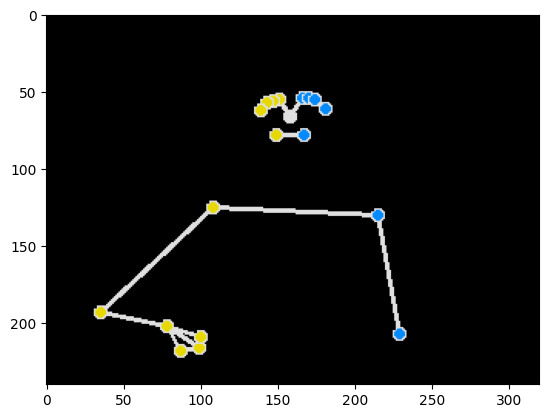

In [36]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

estimated_pose_landmarks = pose_landmarks_A.copy()
# estimated_pose_landmarks[11:25, :-1] = arm_position2pose(pose2arm_position(pose_landmarks_A[11:25], 320, 240), pose_landmarks_A[[11, 12, 23, 24],:-1], 320, 240)

# estimated_pose_landmarks = pose_landmarks_B.copy()
estimated_pose_landmarks[11:25, :-1] = arm_position2pose(pose2arm_position(pose_landmarks_B[11:25], 320, 240), pose_landmarks_A[[11, 12, 23, 24],:-1], 320, 240)

landmark_list = NormalizedLandmarkList()
for landmark in estimated_pose_landmarks:
    landmark_list.landmark.append(mp.tasks.components.containers.NormalizedLandmark(*landmark).to_pb2())

image = np.zeros((240, 320, 3), dtype=np.uint8)
mp_drawing.draw_landmarks(
    image,
    landmark_list,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
)

plt.imshow(image)

In [85]:
half_pose_landmarks_0 = pose_landmarks_A[11:25, :-1]
half_pose_landmarks_1 = pose_landmarks_B[11:25, :-1]

half_pose_landmark_movement = move_arms(half_pose_landmarks_0, half_pose_landmarks_1, 100, 320, 240)

In [86]:
import cv2
out_video_path = 'prueba1.mp4'

out = cv2.VideoWriter(
    filename=out_video_path,
    fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
    fps=25,
    frameSize=(320, 240)
)

pose_landmarks = pose_landmarks_A.copy()

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

for half_pose_landmark in half_pose_landmark_movement:
    pose_landmarks[11:25, :-1] = half_pose_landmark

    landmark_list = NormalizedLandmarkList()
    for landmark in pose_landmarks:
        landmark_list.landmark.append(mp.tasks.components.containers.NormalizedLandmark(*landmark).to_pb2())

    image = np.zeros((240, 320, 3), dtype=np.uint8)
    mp_drawing.draw_landmarks(
        image,
        landmark_list,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
    )

    out.write(image)
out.release()

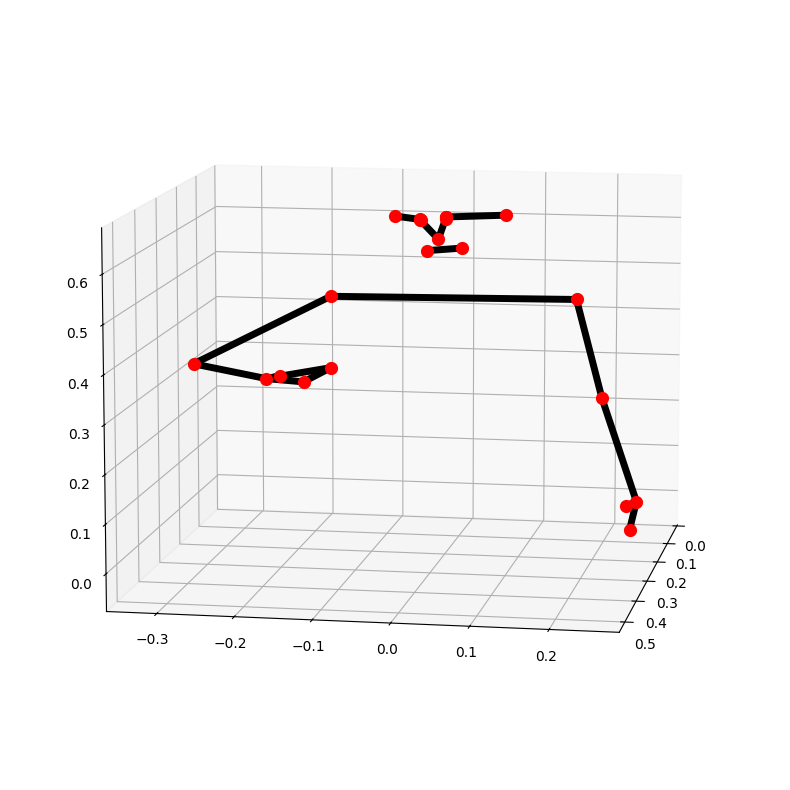

In [39]:
from IPython.display import display, clear_output

pose_world_landmarks_A = total_results["A"]["landmarks"]["pose_world"][27]
pose_world_landmarks_B = total_results["M"]["landmarks"]["pose_world"][35]

pose_world_landmarks = pose_world_landmarks_A.copy()
# pose_world_landmarks[11:25, :-1] = arm_position2pose(
#     pose2arm_position(pose_world_landmarks_A[11:25], 1, 1), pose_world_landmarks_A[[11, 12, 23, 24],:-1], 1, 1)

# pose_world_landmarks = pose_world_landmarks_B.copy()
pose_world_landmarks[11:25, :-1] = arm_position2pose(
    pose2arm_position(pose_world_landmarks_B[11:25], 1, 1), pose_world_landmarks_A[[11, 12, 23, 24],:-1], 1, 1)



mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

landmark_list = LandmarkList()
for landmark in pose_world_landmarks:
    landmark_list.landmark.append(mp.tasks.components.containers.Landmark(*landmark).to_pb2())

mp_drawing.plot_landmarks(landmark_list, mp_pose.POSE_CONNECTIONS)

# for i, pose_world_landmarks in enumerate(total_results["A"]["landmarks"]["pose_world"][27:28]):
#     landmark_list = LandmarkList()
#     for landmark in pose_world_landmarks:
#         landmark_list.landmark.append(mp.tasks.components.containers.Landmark(*landmark).to_pb2())

#     clear_output(wait=True)
#     display(mp_drawing.plot_landmarks(landmark_list, mp_pose.POSE_CONNECTIONS))
#     plt.close()
#     print(i)

In [40]:
pose_world_landmarks_A = total_results["A"]["landmarks"]["pose_world"][27]
pose_world_landmarks_B = total_results["M"]["landmarks"]["pose_world"][35]

half_pose_world_landmarks_0 = pose_world_landmarks_A[11:25, :-1]
half_pose_world_landmarks_1 = pose_world_landmarks_B[11:25, :-1]

half_pose_world_landmark_movement = move_arms(half_pose_world_landmarks_0, half_pose_world_landmarks_1, 20, 1, 1)

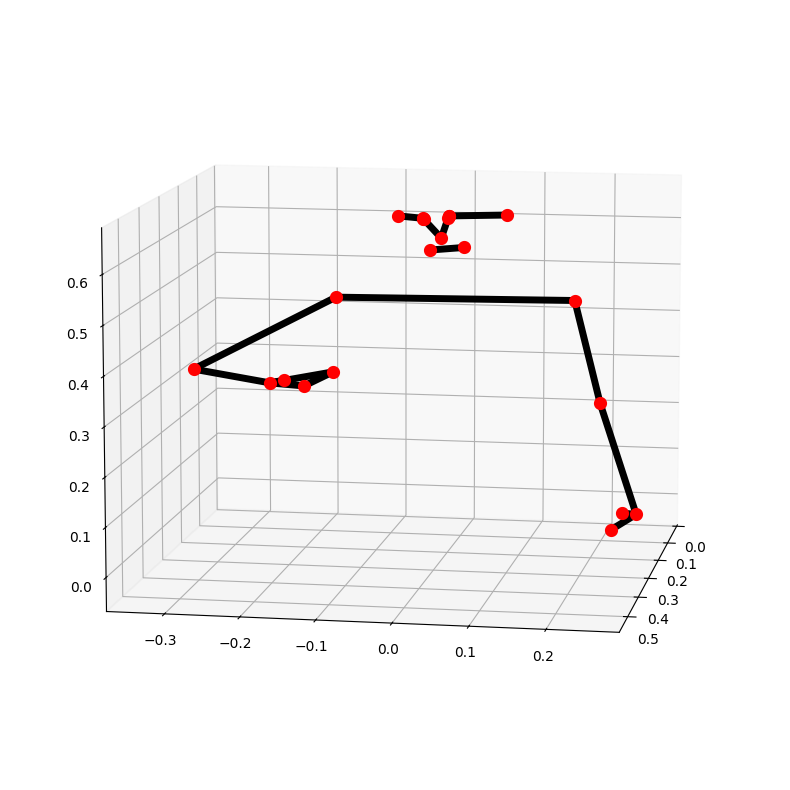

None

In [43]:
pose_world_landmarks = pose_world_landmarks_A.copy()

for half_pose_world_landmarks in half_pose_world_landmark_movement:
    pose_world_landmarks[11:25, :-1] = half_pose_world_landmarks

    landmark_list = LandmarkList()
    for landmark in pose_world_landmarks:
        landmark_list.landmark.append(mp.tasks.components.containers.Landmark(*landmark).to_pb2())

    clear_output(wait=True)
    display(mp_drawing.plot_landmarks(landmark_list, mp_pose.POSE_CONNECTIONS))
    plt.close()

In [51]:
pose_landmarks_A = total_results["A"]["landmarks"]["pose"][27]
pose2arm_position(pose_landmarks_A[11:25], 320, 240)

{'left_shoulder_direction': array([ 0.28130096,  0.93249154, -0.22655972]),
 'left_upperarm_length': 94.04641972095227,
 'left_shoulder_rotation': 1.1881869129761622,
 'left_elbow_angle': 1.993481980310717,
 'left_forearm_length': 116.17307116168583,
 'left_elbow_rotation': 0.459216735516346,
 'left_wrist_rotation': -1.484624410284466,
 'left_wrist_inclination': 0.08137818244143692,
 'left_pinky_vector': array([ 0.        ,  7.59005658, 33.27321082]),
 'left_index_vector': array([ 0.        , -7.59005658, 44.36800029]),
 'left_thumb_vector': array([10.62286793, -2.82067977, 15.26829148]),
 'right_shoulder_direction': array([0.4991802 , 0.03108515, 0.86594044]),
 'right_upperarm_length': 184.3225295489284,
 'right_shoulder_rotation': 0.2587024182885146,
 'right_elbow_angle': 2.343843522682917,
 'right_forearm_length': 260.6934064478994,
 'right_elbow_rotation': -0.11569376618304789,
 'right_wrist_rotation': 1.0019845125948683,
 'right_wrist_inclination': 0.2236256359346491,
 'right_pink

In [49]:
pose_world_landmarks_A = total_results["A"]["landmarks"]["pose_world"][27]
pose2arm_position(pose_world_landmarks_A[11:25], 1, 1)

{'left_shoulder_direction': array([ 0.16516222,  0.94785407, -0.27256944]),
 'left_upperarm_length': 0.22730005026268751,
 'left_shoulder_rotation': 0.925308621531505,
 'left_elbow_angle': 2.677890393934267,
 'left_forearm_length': 0.23385477497999366,
 'left_elbow_rotation': 0.35138195065088595,
 'left_wrist_rotation': -1.353598584133216,
 'left_wrist_inclination': 0.4570400788137248,
 'left_pinky_vector': array([0.        , 0.01895465, 0.0673354 ]),
 'left_index_vector': array([-3.46944695e-18, -1.89546453e-02,  5.89357811e-02]),
 'left_thumb_vector': array([ 0.00811606, -0.01550806,  0.01503097]),
 'right_shoulder_direction': array([0.38028079, 0.67464335, 0.6326475 ]),
 'right_upperarm_length': 0.273559165023439,
 'right_shoulder_rotation': 1.0335230022995774,
 'right_elbow_angle': 1.7006819024321413,
 'right_forearm_length': 0.27967996028533876,
 'right_elbow_rotation': -0.9422196004949209,
 'right_wrist_rotation': 0.4909602595409564,
 'right_wrist_inclination': 0.7598050510466584

In [50]:
pose_world_landmarks_A = total_results["A"]["landmarks"]["pose_world"][10]
pose2arm_position(pose_world_landmarks_A[11:25], 1, 1)

{'left_shoulder_direction': array([ 0.08110796,  0.98142353, -0.17386588]),
 'left_upperarm_length': 0.23391106872359502,
 'left_shoulder_rotation': 0.9950164972624427,
 'left_elbow_angle': 2.3191228756278273,
 'left_forearm_length': 0.19823293720344246,
 'left_elbow_rotation': 0.3144665808336417,
 'left_wrist_rotation': -0.6800724761034774,
 'left_wrist_inclination': 0.15292666866384888,
 'left_pinky_vector': array([0.        , 0.01941001, 0.0825821 ]),
 'left_index_vector': array([-3.46944695e-18, -1.94100062e-02,  7.86493845e-02]),
 'left_thumb_vector': array([ 0.00710486, -0.01142746,  0.01195676]),
 'right_shoulder_direction': array([0.33537527, 0.93355599, 0.12647785]),
 'right_upperarm_length': 0.24050054060099316,
 'right_shoulder_rotation': 1.4425498345264987,
 'right_elbow_angle': 1.8924794932766318,
 'right_forearm_length': 0.18030694714949952,
 'right_elbow_rotation': -0.1300403187286982,
 'right_wrist_rotation': 0.17153607305885749,
 'right_wrist_inclination': 0.2149200132

In [48]:
total_results["A"]["landmarks"]["pose_world"][30]

array([[-4.24156943e-03, -5.99627435e-01, -2.31865227e-01,
         9.99807775e-01],
       [ 1.73092959e-03, -6.37744367e-01, -2.12755233e-01,
         9.99467611e-01],
       [ 2.24528159e-03, -6.40360475e-01, -2.10679397e-01,
         9.99528885e-01],
       [ 2.39038724e-03, -6.40774190e-01, -2.10237294e-01,
         9.99322891e-01],
       [-3.13026905e-02, -6.33506179e-01, -2.15969220e-01,
         9.99616385e-01],
       [-3.14703733e-02, -6.34285867e-01, -2.18521982e-01,
         9.99741793e-01],
       [-3.19241174e-02, -6.36329114e-01, -2.18588337e-01,
         9.99731541e-01],
       [ 5.87765910e-02, -6.16183043e-01, -8.05322379e-02,
         9.99272466e-01],
       [-9.27427262e-02, -6.11878812e-01, -9.57379714e-02,
         9.99829352e-01],
       [ 2.00013835e-02, -5.71750939e-01, -1.90957338e-01,
         9.99850512e-01],
       [-2.63779983e-02, -5.65912187e-01, -1.96918428e-01,
         9.99917924e-01],
       [ 1.48115635e-01, -4.27824646e-01, -4.28478494e-02,
      

In [65]:
total_results["LL"]["landmarks"]["pose_world"][30]

array([[-5.53170824e-03, -6.20001495e-01, -1.84478953e-01,
         9.99849200e-01],
       [ 8.16853659e-04, -6.57751799e-01, -1.62456900e-01,
         9.99554098e-01],
       [ 1.26231113e-03, -6.60648465e-01, -1.60611287e-01,
         9.99596298e-01],
       [ 1.47601136e-03, -6.60805464e-01, -1.60236105e-01,
         9.99471664e-01],
       [-3.29192169e-02, -6.53832138e-01, -1.65882468e-01,
         9.99684989e-01],
       [-3.33837643e-02, -6.54460073e-01, -1.68383375e-01,
         9.99793708e-01],
       [-3.36742178e-02, -6.56654060e-01, -1.68258756e-01,
         9.99795258e-01],
       [ 6.14647903e-02, -6.28405988e-01, -3.02489866e-02,
         9.99305248e-01],
       [-9.35575888e-02, -6.25902772e-01, -4.33640555e-02,
         9.99845982e-01],
       [ 1.91329625e-02, -5.88006735e-01, -1.44669309e-01,
         9.99818444e-01],
       [-2.83655729e-02, -5.83120644e-01, -1.50911987e-01,
         9.99883950e-01],
       [ 1.49766713e-01, -4.36685652e-01, -8.10647290e-03,
      